In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

import tensorflow as tf
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

from sklearn.metrics import classification_report, auc, precision_recall_curve

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Load IMDB Dataset

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(
    path='imdb.npz',
    num_words=None,
    skip_top=0,
    maxlen=None,
    seed=113,
    start_char=1,
    oov_char=2,
    index_from=3)


word_index = tf.keras.datasets.imdb.get_word_index()
start_char = 1
oov_char = 2


inverted_word_index = dict((i + 3, word) for (word, i) in word_index.items())

inverted_word_index[start_char] = '[START]'
inverted_word_index[oov_char] = '[OOV]'

for i in range(len(x_train)):
  x_train[i] = ' '.join(inverted_word_index[i] for i in x_train[i])

for i in range(len(x_test)):
  x_test[i] = ' '.join(inverted_word_index[i] for i in x_test[i])



x_train = np.concatenate((x_train, x_test[10000:]))
y_train = np.concatenate((y_train, y_test[10000:]))

x_dev = x_train[:10000]
y_dev = y_train[:10000]

x_train = x_train[10000:]
y_train = y_train[10000:]

x_test = x_test[:10000]
y_test = y_test[:10000]

print('\nTraining set shape :', x_train.shape)
print('Development set shape :', x_dev.shape)
print('Test set shape :', x_test.shape)

flatten_x_train = [token for doc in x_train for token in nltk.tokenize.word_tokenize(doc)]


def average_doc_length(docs_tokenized):
  doc_sizes = []

  for doc in docs_tokenized:
    doc_sizes.append(len(doc) - 3)

  return int(np.mean(np.array(doc_sizes)))



print('\nVocabulary size :', len(set(flatten_x_train)) - 3)

print('\nAverage doc length of training set :', average_doc_length([nltk.tokenize.word_tokenize(doc) for doc in x_train]))
print('Average doc length of development set :', average_doc_length([nltk.tokenize.word_tokenize(doc) for doc in x_dev]))
print('Average doc length of test set :', average_doc_length([nltk.tokenize.word_tokenize(doc) for doc in x_test]))


Training set shape : (30000,)
Developement set shape : (10000,)
Test set shape : (10000,)

Vocabulary size : 66806

Average doc length of training set : 238
Average doc length of developement set : 242
Average doc length of test set : 234


# Feature Extraction (TF-IDF)

In [ ]:
tfidf_vectorizer = TfidfVectorizer(
  ngram_range = (1, 3),
  max_features = 5000,
  sublinear_tf = True,
  stop_words = stopwords.words('english'))

x_train_vectorized = tfidf_vectorizer.fit_transform(x_train)
x_test_vectorized = tfidf_vectorizer.transform(x_test)
x_dev_vectorized = tfidf_vectorizer.transform(x_dev)

# Feature Selection (SelectKBest)

In [ ]:
k_best = SelectKBest(chi2, k=2000)

x_train_tfidf_selected = k_best.fit_transform(x_train_vectorized, y_train)
x_dev_tfidf_selected = k_best.transform(x_dev_vectorized)
x_test_tfidf_selected = k_best.transform(x_test_vectorized)

# Dimensionality Reduction (TruncatedSVD)

In [ ]:
svd = TruncatedSVD(n_components=500, random_state=4321)

x_train_tfidf_svd = svd.fit_transform(x_train_tfidf_selected)
x_dev_tfidf_svd = svd.transform(x_dev_tfidf_selected)
x_test_tfidf_svd = svd.transform(x_test_tfidf_selected)

In [ ]:
target_names = ['negative', 'positive']

print('Training set shape :', x_train_tfidf_svd.shape)
print('Development set shape :', x_dev_tfidf_svd.shape)
print('Test set shape :', x_test_tfidf_svd.shape)

Training set shape : (30000, 500)
Developement set shape : (10000, 500)
Test set shape : (10000, 500)


In [ ]:
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 3.8 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt

def model_builder(hp):

  hp_units = hp.Int('units', min_value=32, max_value=256, step=32)
  hp_units_2 = hp.Int('units_2', min_value=32, max_value=256, step=32)
  hp_dropout = hp.Float('rate', min_value=0.1, max_value=0.5, step=0.2)
  hp_learning_rate = hp.Float('learning_rate', min_value=0.0001, max_value=0.1, step=10, sampling='log')


  model = Sequential()
  model.add(Dense(units=hp_units, input_dim=x_train_tfidf_svd.shape[1] , activation='relu'))
  model.add(Dense(units=hp_units_2,  activation='relu'))
  model.add(Dropout(rate = hp_dropout))
  model.add(Dense(1, activation='sigmoid'))

  model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(
    from_logits=False),
    optimizer=Adam(learning_rate=hp_learning_rate),
    metrics=['accuracy']
    )

  return model

tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=20,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')


stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


tuner.search(x_train_tfidf_svd, y_train, epochs=50, validation_data=(x_dev_tfidf_svd, y_dev), callbacks=[stop_early])


# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')}, in the second densely-connected layer is {best_hps.get('units_2')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')},the dropout probability is: {best_hps.get('rate')}.
""")

Trial 30 Complete [00h 01m 41s]
val_accuracy: 0.8816999793052673

Best val_accuracy So Far: 0.8826000094413757
Total elapsed time: 00h 20m 15s

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 64, in the second densely-connected layer is 32 and the optimal learning rate for the optimizer
is 0.001,the dropout probability is: 0.1.



In [ ]:
model = tuner.hypermodel.build(best_hps)

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                32064     
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 34177 (133.50 KB)
Trainable params: 34177 (133.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
import time

with tf.device('/device:GPU:0'):

  start_training_time = time.time()

  history = model.fit(
      x_train_tfidf_svd,
      y_train,
      validation_data=(x_dev_tfidf_svd, y_dev),
      batch_size=40,
      epochs=50,
      shuffle=True
      )

  end_training_time = time.time()

  print(f'\nTraining time: {time.strftime("%H:%M:%S", time.gmtime(end_training_time - start_training_time))} sec\n')

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
750/750 [==============================] - 4s 4ms/step - loss: 0.6718 - accuracy: 0.5900 - val_loss: 0.5879 - val_accuracy: 0.8551
Epoch 2/50
750/750 [==============================] - 3s 4ms/step - loss: 0.4121 - accuracy: 0.8497 - val_loss: 0.3077 - val_accuracy: 0.8790
Epoch 3/50
750/750 [==============================] - 4s 5ms/step - loss: 0.2905 - accuracy: 0.8799 - val_loss: 0.2935 - val_accuracy: 0.8770
Epoch 4/50
750/750 [==============================] - 3s 4ms/step - loss: 0.2769 - accuracy: 0.8836 - val_loss: 0.2837 - val_accuracy: 0.8827
Epoch 5/50
750/750 [==============================] - 3s 4ms/step - loss: 0.2730 - accuracy: 0.8871 - val_loss: 0.2829 - val_accuracy: 0.8821
Epoch 6/50
750/750 [==============================] - 3s 4ms/step - loss: 0.2728 - accuracy: 0.8855 - val_loss: 0.2841 - val_accuracy: 0.8808
Epoch 7/50
750/750 [==============================] - 3s 4ms/step - loss: 0.2704 - accuracy: 0.8869 - val_loss: 0.2843 - val_accuracy: 0.8813
Epoch 

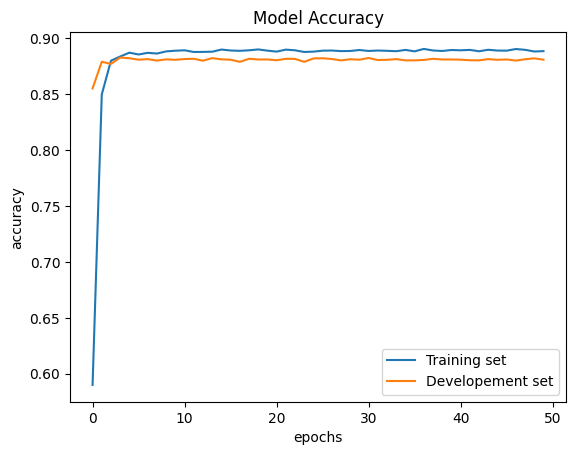

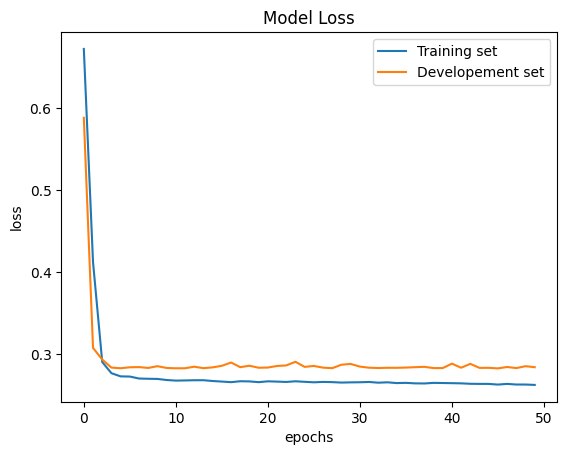

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt


# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['Training set', 'Development set'], loc='lower right')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['Training set', 'Development set'], loc='upper right')
plt.show()

# Metrics

Precision , Recall , F1 , AUC scores for each classifier

In [ ]:
lr = LogisticRegression(solver = 'liblinear', max_iter = 50, C=0.9)
lr.fit(x_train_tfidf_svd, y_train)

dummy = DummyClassifier(strategy="uniform")
dummy.fit(x_train_tfidf_svd , y_train)

model = tuner.hypermodel.build(best_hps)
model.fit(x_train_tfidf_svd, y_train, validation_data=(x_dev_tfidf_svd, y_dev), batch_size=40, epochs=best_epoch, shuffle=True)


lr_predictions_train = lr.predict(x_train_tfidf_svd)
lr_predictions_train_proba = lr.predict_proba(x_train_tfidf_svd)
lr_precision_train, lr_recall_train, thresholds = precision_recall_curve(y_train, lr_predictions_train_proba[:,1])

lr_predictions_dev = lr.predict(x_dev_tfidf_svd)
lr_predictions_dev_proba = lr.predict_proba(x_dev_tfidf_svd)
lr_precision_dev, lr_recall_dev, thresholds = precision_recall_curve(y_dev, lr_predictions_dev_proba[:,1])

lr_predictions_test = lr.predict(x_test_tfidf_svd)
lr_predictions_test_proba = lr.predict_proba(x_test_tfidf_svd)
lr_precision_test, lr_recall_test, thresholds = precision_recall_curve(y_test, lr_predictions_test_proba[:,1])


dummy_predictions_train = dummy.predict(x_train_tfidf_svd)
dummy_predictions_train_proba = dummy.predict_proba(x_train_tfidf_svd)
dummy_precision_train, dummy_recall_train, thresholds = precision_recall_curve(y_train, dummy_predictions_train_proba[:,1])

dummy_predictions_dev = dummy.predict(x_dev_tfidf_svd)
dummy_predictions_dev_proba = dummy.predict_proba(x_dev_tfidf_svd)
dummy_precision_dev, dummy_recall_dev, thresholds = precision_recall_curve(y_dev, dummy_predictions_dev_proba[:,1])

dummy_predictions_test = dummy.predict(x_test_tfidf_svd)
dummy_predictions_test_proba = dummy.predict_proba(x_test_tfidf_svd)
dummy_precision_test, dummy_recall_test, thresholds = precision_recall_curve(y_test, dummy_predictions_test_proba[:,1])


mlp_predictions_train = model.predict(x_train_tfidf_svd)
mlp_precision_train, mlp_recall_train, thresholds = precision_recall_curve(y_train, mlp_predictions_train)

mlp_predictions_dev = model.predict(x_dev_tfidf_svd)
mlp_precision_dev, mlp_recall_dev, thresholds = precision_recall_curve(y_dev, mlp_predictions_dev)

mlp_predictions_test = model.predict(x_test_tfidf_svd)
mlp_precision_test, mlp_recall_test, thresholds = precision_recall_curve(y_test, mlp_predictions_test)



print('\n--------- Baseline 1 Dummy Classifier ---------\n')
print('Training set\n')
print(classification_report(y_train, dummy_predictions_train, target_names = target_names))
print('AUC training :', auc(dummy_recall_train, dummy_precision_train), '\n')
print('\nDevelopment set\n')
print(classification_report(y_dev, dummy_predictions_dev, target_names = target_names))
print('AUC development :', auc(dummy_recall_dev, dummy_precision_dev), '\n')
print('\nTest set\n')
print(classification_report(y_test, dummy_predictions_test, target_names = target_names))
print('AUC test :', auc(dummy_recall_test, dummy_precision_test), '\n')


print('\n--------- Baseline 2 Logistic Regression ---------\n')
print('Training set\n')
print(classification_report(y_train, lr_predictions_train, target_names = target_names))
print('AUC training :', auc(lr_recall_train, lr_precision_train), '\n')
print('\nDevelopment set\n')
print(classification_report(y_dev, lr_predictions_dev, target_names = target_names))
print('AUC development :', auc(lr_recall_dev, lr_precision_dev), '\n')
print('\nTest set\n')
print(classification_report(y_test, lr_predictions_test, target_names = target_names))
print('AUC test :', auc(lr_recall_test, lr_precision_test), '\n')


print('\n--------- Custom MLP ---------\n')
print('Training set\n')
print(classification_report(y_train, np.round(mlp_predictions_train), target_names = target_names))
print('AUC training :', auc(mlp_recall_train, mlp_precision_train), '\n')
print('\nDevelopment set\n')
print(classification_report(y_dev, np.round(mlp_predictions_dev), target_names = target_names))
print('AUC development :', auc(mlp_recall_dev, mlp_precision_dev), '\n')
print('\nTest set\n')
print(classification_report(y_test, np.round(mlp_predictions_test), target_names = target_names))
print('AUC test :', auc(mlp_recall_test, mlp_precision_test))

Epoch 1/4
750/750 [==============================] - 4s 4ms/step - loss: 0.6753 - accuracy: 0.5828 - val_loss: 0.5975 - val_accuracy: 0.8425
Epoch 2/4
750/750 [==============================] - 3s 4ms/step - loss: 0.4215 - accuracy: 0.8433 - val_loss: 0.3126 - val_accuracy: 0.8779
Epoch 3/4
750/750 [==============================] - 3s 5ms/step - loss: 0.2919 - accuracy: 0.8794 - val_loss: 0.2868 - val_accuracy: 0.8814
Epoch 4/4
313/313 [==============================] - 1s 2ms/step

--------- Baseline 1 Dummy Classifier ---------

Training set

              precision    recall  f1-score   support

    negative       0.50      0.50      0.50     15026
    positive       0.50      0.50      0.50     14974

    accuracy                           0.50     30000
   macro avg       0.50      0.50      0.50     30000
weighted avg       0.50      0.50      0.50     30000

AUC training : 0.7495666666666667 


Developement set

              precision    recall  f1-score   support

    negativ